In [1]:
!pip install --upgrade tspiral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from tsprial.forecasting import *

In [3]:
# utility function to generate data

def gen_sinusoidal(timesteps, amp, freq, noise):
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    return y

def gen_randomwalk(timesteps, noise):
    y = np.random.normal(0,noise, (timesteps,))
    return y.cumsum()

def gen_ts(timesteps, random_state=0):
    np.random.seed(i)
    seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
    seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2])
    trend = LinearRegression().fit(X, rw).predict(X)
    return seas1 + seas2 + trend

In [4]:
# generate data

n_series, timesteps = 10, 3_000

exog = np.hstack([
    gen_sinusoidal(timesteps=timesteps, amp=1, freq=24, noise=0).reshape(-1,1),
    gen_sinusoidal(timesteps=timesteps, amp=1, freq=24*7, noise=0).reshape(-1,1)
])

df = {}
for i in range(n_series):
    df[f'ts_{i}'] = gen_ts(timesteps, i)
df = pd.DataFrame(df)


df.shape, exog.shape

((3000, 10), (3000, 2))

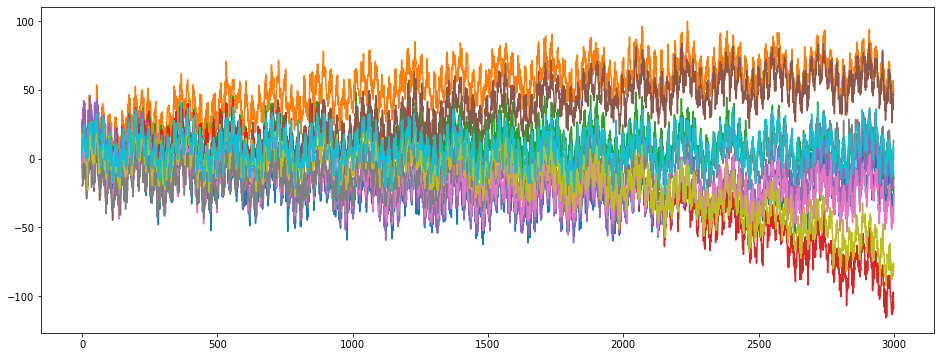

In [5]:
# plot timeseries

df.sample(n=10, random_state=0, axis=1).plot(legend=False, figsize=(16,6))

In [6]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(exog, df, test_size=300, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2700, 2), (300, 2), (2700, 10), (300, 10))

# Univariate Forecasting

In [7]:
# fit on univariate timeseries

ts_id = ['ts_3']

model = ForecastingStacked(
    [DecisionTreeRegressor(), Ridge()],
    test_size=len(y_test),
    lags=range(1,24*7+1),  
    use_exog=False
)
model.fit(np.arange(len(y_train)), y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(), Ridge()],
                   lags=range(1, 169), test_size=300)

In [8]:
# score on univariate timeseries

model.score(np.arange(len(y_test)), y_test[ts_id], scoring='mse')

32.65659271396401

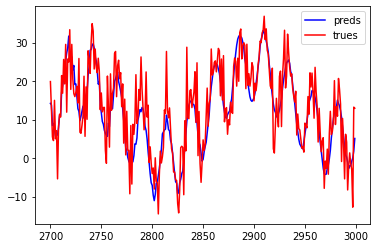

In [9]:
# plot true vs pred on test data

plt.plot(y_test.index, model.predict(np.arange(len(y_test))), c='blue', label='preds')
plt.plot(y_test.index, y_test[ts_id].values, c='red', label='trues')
plt.legend(); plt.show()

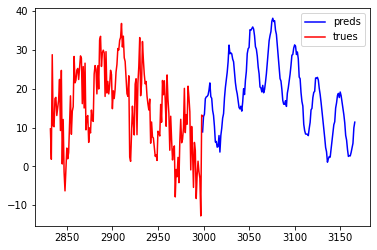

In [10]:
# plot future forecasts (no need to refit)

plt.plot(np.arange(168) + df.index[-1], model.predict(np.arange(168), last_y=df[ts_id]), c='blue', label='preds')
plt.plot(y_test.tail(168).index, df[ts_id].tail(168).values, c='red', label='trues')
plt.legend(); plt.show()

In [11]:
# fit on univariate timeseries using exogenous variables

model = ForecastingStacked(
    [DecisionTreeRegressor(), Ridge()],
    test_size=len(y_test),
    lags=range(1,24*7+1), 
    use_exog=True
)
model.fit(X_train, y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(), Ridge()],
                   lags=range(1, 169), test_size=300, use_exog=True)

In [12]:
# score on univariate timeseries using exogenous variables

model.score(X_test, y_test[ts_id], scoring='mse')

44.88667320713999

In [13]:
# fit on univariate timeseries using exogenous variables plus exogenous lags

model = ForecastingStacked(
    [DecisionTreeRegressor(), Ridge()],
    test_size=len(y_test),
    lags=range(1,24*7+1), 
    use_exog=True,
    exog_lags=range(1,6),
)
model.fit(X_train, y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(), Ridge()],
                   exog_lags=range(1, 6), lags=range(1, 169), test_size=300,
                   use_exog=True)

In [14]:
# score on univariate timeseries using exogenous variables plus exogenous lags

model.score(X_test, y_test[ts_id], scoring='mse')

45.059070208906284

# Multivariate Forecasting

In [15]:
# fit on multivariate timeseries

ts_id = ['ts_1', 'ts_2', 'ts_3']

model = ForecastingStacked(
    [DecisionTreeRegressor(), Ridge()],
    test_size=len(y_test),
    lags=range(1,24*7+1), 
    use_exog=False
)
model.fit(np.arange(len(y_train)), y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(), Ridge()],
                   lags=range(1, 169), test_size=300)

In [16]:
# score on multivariate timeseries

model.score(np.arange(len(y_test)), y_test[ts_id], scoring='mse', uniform_average=False)

array([36.65258714, 43.22732127, 33.72234228])

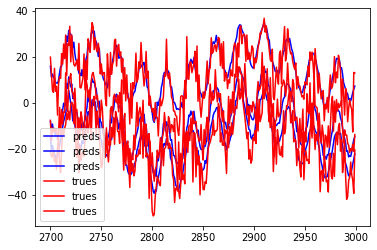

In [17]:
# plot true vs pred on test data

plt.plot(y_test.index, model.predict(np.arange(len(y_test))), c='blue', label='preds')
plt.plot(y_test.index, y_test[ts_id].values, c='red', label='trues')
plt.legend(); plt.show()

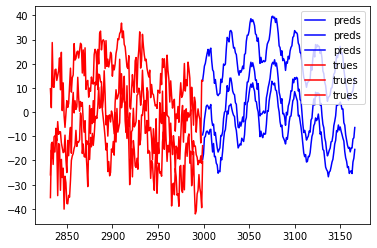

In [18]:
# plot future forecasts (no need to refit)

plt.plot(np.arange(168) + df.index[-1], model.predict(np.arange(168), last_y=df[ts_id]), c='blue', label='preds')
plt.plot(y_test.tail(168).index, df[ts_id].tail(168).values, c='red', label='trues')
plt.legend(); plt.show()

In [19]:
# fit on multivariate timeseries using exogenous variables

model = ForecastingStacked(
    [DecisionTreeRegressor(), Ridge()],
    test_size=len(y_test),
    lags=range(1,24*7+1), 
    use_exog=True
)
model.fit(X_train, y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(), Ridge()],
                   lags=range(1, 169), test_size=300, use_exog=True)

In [20]:
# score on multivariate timeseries using exogenous variables

model.score(X_test, y_test[ts_id], scoring='mse', uniform_average=False)

array([35.54711013, 35.9505686 , 31.85080861])

In [21]:
# fit on multivariate timeseries using exogenous variables plus exogenous lags

model = ForecastingStacked(
    [DecisionTreeRegressor(), Ridge()],
    test_size=len(y_test),
    lags=range(1,24*7+1), 
    use_exog=True,
    exog_lags=range(1,6),
)
model.fit(X_train, y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(), Ridge()],
                   exog_lags=range(1, 6), lags=range(1, 169), test_size=300,
                   use_exog=True)

In [22]:
# score on univariate timeseries using exogenous variables plus exogenous lags

model.score(X_test, y_test[ts_id], scoring='mse')

34.562327349758895

# Parameter Tuning

In [23]:
# univariate timeseries forecasting parameters tuning

ts_id = ['ts_3']
CV = TimeSeriesSplit(5, test_size=24*7)

model1 = GridSearchCV(
    ForecastingCascade(
        DecisionTreeRegressor(),
        lags=range(1,24*7+1), 
        use_exog=False
    ), 
    param_grid={'estimator__max_depth': [10,20,None]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
model1.fit(np.arange(len(y_train)), y_train[ts_id])

model2 = GridSearchCV(
    ForecastingCascade(
        Ridge(),
        lags=range(1,24*7+1),
        use_exog=False
    ), 
    param_grid={'estimator__alpha': [1,2,3,5,10]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
model2.fit(np.arange(len(y_train)), y_train[ts_id])

model = ForecastingStacked(
    [DecisionTreeRegressor(**{p.replace('estimator__',''): v for p,v in model1.best_params_.items()}), 
     Ridge(**{p.replace('estimator__',''): v for p,v in model2.best_params_.items()})],
    test_size=len(y_test),
    lags=range(1,24*7+1), 
    use_exog=False
)
model.fit(np.arange(len(y_train)), y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(max_depth=10),
                               Ridge(alpha=10)],
                   lags=range(1, 169), test_size=300)

In [24]:
# score on univariate timeseries with parameters tuning

model.score(np.arange(len(y_test)), y_test[ts_id], scoring='mse')

34.24122126754264

In [25]:
# multivariate timeseries forecasting parameters tuning

ts_id = ['ts_1', 'ts_2', 'ts_3']
CV = TimeSeriesSplit(5, test_size=24*7)

model1 = GridSearchCV(
    ForecastingCascade(
        DecisionTreeRegressor(),
        lags=range(1,24*7+1), 
        use_exog=False
    ), 
    param_grid={'estimator__max_depth': [10,20,None]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
model1.fit(np.arange(len(y_train)), y_train[ts_id])

model2 = GridSearchCV(
    ForecastingCascade(
        Ridge(),
        lags=range(1,24*7+1),
        use_exog=False
    ), 
    param_grid={'estimator__alpha': [1,2,3,5,10]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
model2.fit(np.arange(len(y_train)), y_train[ts_id])

model = ForecastingStacked(
    [DecisionTreeRegressor(**{p.replace('estimator__',''): v for p,v in model1.best_params_.items()}), 
     Ridge(**{p.replace('estimator__',''): v for p,v in model2.best_params_.items()})],
    test_size=len(y_test),
    lags=range(1,24*7+1), 
    use_exog=False
)
model.fit(np.arange(len(y_train)), y_train[ts_id])

ForecastingStacked(estimators=[DecisionTreeRegressor(max_depth=10),
                               Ridge(alpha=10)],
                   lags=range(1, 169), test_size=300)

In [26]:
# score on multivariate timeseries with parameters tuning

model.score(np.arange(len(y_test)), y_test[ts_id], scoring='mse', uniform_average=False)

array([37.85877387, 42.16352668, 32.69358599])